# Practicing PCA on Two Datasets
In this exercise, we explore the application of PCA on two different datasets. One of them is synthetic and the other one is available through the sklearn package.

# Submission
- There are four tasks for you.
- Report the results and answer the questions in the pdf file that you would submit along with your other solutions.
- Additionally, submit your code in the same Jupiter notebook format. (keep the overall format of the notebook unchanged)


## Packages
First of all, let's import the packages we need for this assignment.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.utils.frame import extract_module_locals
from scipy.linalg import svd
from sklearn.datasets import fetch_lfw_people
from sklearn.utils import shuffle
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# get correct path
try:
  WORKING_DIR = os.path.dirname(extract_module_locals()[1]['__session__'])
except:
  WORKING_DIR = os.getcwd()

## Datasets:
First dataset is LFW (Labeled Faces in the Wild) dataset. And the second one is a synthetic dataset that will be explained in a few

### First Dataset: Labeled Faces in the Wild (LFW)

The **Labeled Faces in the Wild (LFW)** dataset is a collection of face images. This dataset contains images of famous individuals collected from the web, with each image labeled by the identity of the person in the image.

#### Features:
- **Image data**: Each image is a grayscale 2D image of size 62x47 pixels, representing a person's face.
- **Label**: The name of the person in the image, which serves as the class label.

#### Dataset Properties:
- **Number of Samples**:
  - Full dataset: 13,233 images.
  - Reduced version (available via `sklearn`): 1,288 images.
  - "George W Bush" class: 530 images.
- **Number of Classes**:
  - Full dataset: 5749 unique individuals, with varying numbers of images per person.
  - Reduced version (available via `sklearn`): 7 classes.
- **Image Size**: Each image is 62x47 pixels (grayscale), giving 2,914 features per image (62 × 47 = 2,914).
- **Format**: The dataset provides images as NumPy arrays and labels as strings.


#### Loading LFW dataset:

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.5)
n_samples_LFW, image_height, image_width = lfw_people.images.shape

X_LFW = lfw_people.data
Y_LFW = lfw_people.target

Y_names_LFW = lfw_people.target_names
n_classes_LFW = Y_names_LFW.shape[0]

print('Dataset properties:')
print('\t Number of data points: %d' % X_LFW.shape[0])
print('\t Number of features: %d' % X_LFW.shape[1])
print('\t Number of classes: %d' % n_classes_LFW)
print('\t Width of each image: %d' % image_width)
print('\t Height of each image: %d' % image_height)

Dataset properties:
	 Number of data points: 1288
	 Number of features: 2914
	 Number of classes: 7
	 Width of each image: 47
	 Height of each image: 62


#### Visualization:

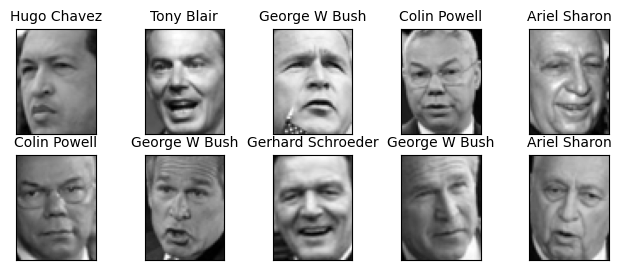

In [4]:
def plot_faces(images, labels, names, n_row, n_col):
  """Helper function to plot a gallery of portraits"""
  f = plt.figure(figsize=(8, 3))
  for i in range(n_row * n_col):
    subfigure = f.add_subplot(n_row, n_col, i + 1)
    subfigure.imshow(images[i].reshape((image_height, image_width)), cmap=plt.cm.gray)
    subfigure.set_title(names[labels[i]], fontsize=10)
    # Removing the axes
    plt.xticks(())
    plt.yticks(())
  plt.show()


plot_faces(X_LFW, Y_LFW, Y_names_LFW, 2, 5)

### Second Dataset: Two Noisy Circles (TNC)


This dataset contains synthetic samples of two noisy circles in 2D space. Each circle has a different radius, and noise is added to the points to simulate imperfect real-world data.

#### Features:
- **coord_x**: The x-coordinate of the data point in 2D space.
- **coord_y**: The y-coordinate of the data point in 2D space.
- **label**: A categorical label indicating to which circle the point belongs:
  - `1`: Points belonging to the inner circle (radius = 2).
  - `2`: Points belonging to the outer circle (radius = 10).

#### Data Description:
1. **Inner Circle (Label 1)**:
   - Radius: 2.
   - Number of points: 1500.
   - Gaussian noise added to both x and y coordinates with a noise level of 0.2.
2. **Outer Circle (Label 2)**:
   - Radius: 10 units.
   - Number of points: 1500.
   - Gaussian noise added with the same level of 0.2.

#### Dataset Properties:
- **Number of Samples**: 3000 (1500 samples for each circle).
- **Noise Level**: 0.2 (Gaussian noise applied independently to the x and y coordinates).
- **Labels**: 1 for the inner circle, 2 for the outer circle.


#### Generating TNC Dataset:

In [5]:
# Parameters for both circles
radius1 = 2
radius2 = 10
num_points = 1500
noise_level = 0.2

In [6]:
# Function to generate noisy points on a circle with a label
def generate_noisy_circle_points_with_labels(radius: int, num_points: int, noise_level: float, label: int):
  # Random angles for polar coordinates
  theta = np.random.uniform(0, 2 * np.pi, num_points)
  # Coordinates on the circle (without noise)
  coord_x = radius * np.cos(theta)
  coord_y = radius * np.sin(theta)
  # Add noise
  coord_x += np.random.normal(0, noise_level, num_points)
  coord_y += np.random.normal(0, noise_level, num_points)
  # Create labels
  labels = np.full(num_points, label)
  return coord_x, coord_y, labels


if not os.path.exists(SYNTHETIC_FILE := os.path.join(WORKING_DIR, 'synthetic_circle_data.csv')):
  # Generate points for both circles
  coord_x1, coord_y1, labels1 = generate_noisy_circle_points_with_labels(radius1, num_points, noise_level, 1)
  coord_x2, coord_y2, labels2 = generate_noisy_circle_points_with_labels(radius2, num_points, noise_level, 2)

  # Combine the two circles
  coord_x = np.concatenate([coord_x1, coord_x2])
  coord_y = np.concatenate([coord_y1, coord_y2])
  labels = np.concatenate([labels1, labels2])

  # Create DataFrame for easy manipulation and shuffle
  data = pd.DataFrame({'coord_x': coord_x, 'coord_y': coord_y, 'label': labels})
  data = shuffle(data).reset_index(drop=True)

  # Save the shuffled data to a CSV file
  data.to_csv(SYNTHETIC_FILE, index=False)

#### Loading TNC dataset:

In [7]:
# Load the dataset
data = pd.read_csv(SYNTHETIC_FILE)

# Split features and labels
X_TNC = data[['coord_x', 'coord_y']].values
Y_TNC = data['label'].values


#### Visualization:
When plotted, the dataset exhibits two concentric, noisy circles. The inner circle is labeled as `1` and colored red, while the outer circle is labeled as `2` and colored blue. Both circles have Gaussian noise applied, which makes the data more realistic by introducing variance in the points' positions.

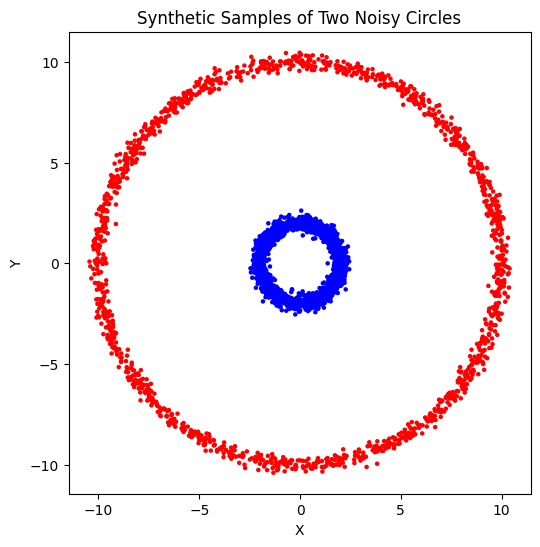

In [8]:
# Plot the points, color-coded by label (1 -> red, 2 -> blue)
plt.figure(figsize=(6, 6))
plt.scatter(data['coord_x'], data['coord_y'], c=data['label'], cmap='bwr', s=5)

# Set equal aspect ratio to make the circles look accurate
plt.gca().set_aspect('equal', adjustable='box')

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synthetic Samples of Two Noisy Circles')

plt.show()

# <font color="red">Task 1: Eigenfaces (5 points) </font>

**NOTE:** In this task you only work with LFW dataset.

The below code is supposed to generate the "average faces" as well as the first "eigen faces" for George W Bush class.

**NOTE:** For the rest of the assignment you just work with "George W Bush" class

## Select "George W Bush" class
Run the below code to select a specific class of faces.

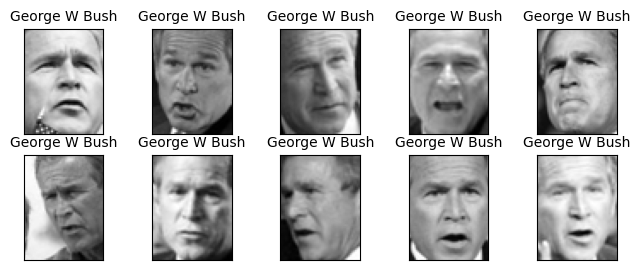

(530, 2914)


In [9]:
class_name_bush = 'George W Bush'
class_indx_bush = list(Y_names_LFW).index(class_name_bush)
X_bush = X_LFW[Y_LFW == class_indx_bush, :]
Y_bush = Y_LFW[Y_LFW == class_indx_bush]
plot_faces(X_bush, Y_bush, Y_names_LFW, 2, 5)

print(X_bush.shape)

## Implementation
In this section you need to implement `centeralize_data()` and `pca_components()` functions.

We use SVD factorization in order to implement PCA. In the following link you can find useful information of how to do so. It explains the connection between PCA and SVD. https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca


You may check the video with link https://youtu.be/nbBvuuNVfco?si=SfJSE85fjMUMiboK for detailed explanation of SVD.

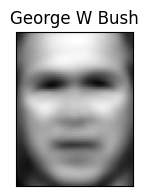

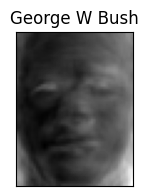

In [10]:
def centeralize_data(data):
  return data - (data_mean := np.mean(data, axis=0).reshape(1, -1)), data_mean


def pca_components(Vt, n_components):
  return Vt[:n_components]


def normalized_svd(data):
  XN, data_mean = centeralize_data(data)
  return *svd(XN), data_mean


def average_image_class(images):
  return np.mean(images, axis=0)


def eigen_face_class(images):
  return pca_components(normalized_svd(images)[2], n_components=1)


def plot_class_representatives(images, class_name, aggregator):
  f = plt.figure(figsize=(2, 2))
  subfigure = f.add_subplot(1, 1, 1)
  subfigure.imshow(aggregator(images).reshape((image_height, image_width)), cmap=plt.cm.gray)
  subfigure.set_title(class_name)
  # Removing the axes
  plt.xticks(())
  plt.yticks(())
  plt.show()


plot_class_representatives(X_bush, class_name_bush, aggregator=average_image_class)
plot_class_representatives(X_bush, class_name_bush, aggregator=eigen_face_class)

# <font color="red">Task 2: PCA Transformation and Reconstructing (15 points) </font>

In this task, we focus on implementing two fundamental functions for Principal Component Analysis (PCA):

- **`pca_transform()`**
- **`pca_inverse_transform()`**


## <font color="#D2691E">Part A (10 points): </font>

- **`pca_transform()`**: Projects the original data onto a new space using PCA via Singular Value Decomposition (SVD).

  ### Inputs:

    - **`X` (ndarray)**:
      - The input data matrix to be transformed. Each row represents a sample, and each column represents a feature.

    - **`n_components` (int)**:
      - The number of principal components to retain.
      - Controls the dimensionality reduction by selecting the top `n_components`.
      - For instance, setting `n_components=2` reduces the data to 2D space by projecting it onto the first two principal components.

  ### Outputs:

    - **`transformed_data` (ndarray)**:
      - The data projected onto the top `n_components` principal components, resulting in a reduced-dimension representation of the original data.

    - **`Vt` (ndarray)**:
      - The right singular vectors from SVD, needed for inverse transformation to reconstruct the original data.

    - **`data_mean` (ndarray)**:
      - The mean of the original data, which is subtracted during the transformation process and added back during the reconstruction.

In [11]:
def pca_transform(X, n_components):
  """
  Transforms the data into a new space using PCA via SVD.

  Parameters:
  - X: ndarray
      The input data matrix to be transformed.
  - n_components: int
      The number of principal components to retain.

  Returns:
  - transformed_data: ndarray
      The data projected onto the top n_components principal components.
  - Vt: ndarray
      The right singular vectors from SVD, needed for inverse transformation.
  - data_mean: ndarray
      The mean of the original data, required to reconstruct the data.
  """
  U, s, *result = normalized_svd(X)
  return U[:, :n_components] * s[:n_components], *result

### We apply PCA transform to both datasets:

For TNC dataset we set n_components=2

For LFW dataset we set n_components=100



---

**IMPORTANT NOTE:** Remember that in TNC dataset, we are working with X_TNC that can have two labels. But in the LFW dataset, we are just working with X_bush.

---

In [12]:
n_components = 100

# Transform the X_bush data using the specified number of principal components
T_bush, Vt_bush, mean_bush = pca_transform(X_bush, n_components)


n_components = 2

# Transform the X_TNC data using the specified number of principal components
T_TNC, Vt_TNC, mean_TNC = pca_transform(X_TNC, n_components)

## <font color="#D2691E">Part B (5 points): </font>

- **`pca_inverse_transform()`**: Reconstructs the original data from its transformed representation.

    - **`transformed_data` (ndarray)**:
      - The data that has been projected into the lower-dimensional space using PCA.
      - This is the result of the `pca_transform()` function and represents the coordinates of the original data in the new principal component space.

    - **`Vt` (ndarray)**:
      - The right singular vectors from SVD (the principal components), used for the reconstruction.
      - This matrix is obtained from the SVD process, and only the top `n_components` vectors are used for reconstruction.

    - **`n_components` (int)**:
      - The number of principal components that were used for the transformation.
      - Determines how many components to use in the reconstruction process.

    - **`data_mean` (ndarray)**:
      - The mean of the original data.
      - This is used to reverse the centering operation that was applied to the data before performing PCA.


In [13]:
def pca_inverse_transform(transformed_data, Vt, n_components, data_mean):
  """
  Reconstructs the original data from its transformed representation.

  Parameters:
  - transformed_data: ndarray
      The data in the reduced-dimensional space.
  - Vt: ndarray
      The right singular vectors from SVD, used to reconstruct the original space.
  - n_components: int
      The number of principal components that were used for the transformation.
  - data_mean: ndarray
      The mean of the original data (used for centering).

  Returns:
  - reconstructed_data: ndarray
      The data reconstructed back into the original space.
  """
  return transformed_data @ pca_components(Vt, n_components) + data_mean

### We apply PCA inverse transform to both new datasets:


For TNC dataset we set n_components=2

For LFW dataset we set n_components=100

In [14]:
n_components = 100

# Reconstruct the X_bush data back to the original image space.
reconstructed_bush = pca_inverse_transform(T_bush, Vt_bush, n_components, mean_bush)


n_components = 2

# Reconstruct the X_TNC data back to the original 2D space.
reconstructed_TNC = pca_inverse_transform(T_TNC, Vt_TNC, n_components, mean_TNC)

### TNC Visualization:
Since we are in the 2 dimension for the circle dataset it is easy to plot the transformation results:


---


As shown in the TNC visualization, the dimensionality of the data is not being reduced, as we maintain the number of components at two. This ensures no information is lost. The only noticeable difference is a rotation of the data.


Observe that here, we plot each coordinate with its corresponding label.

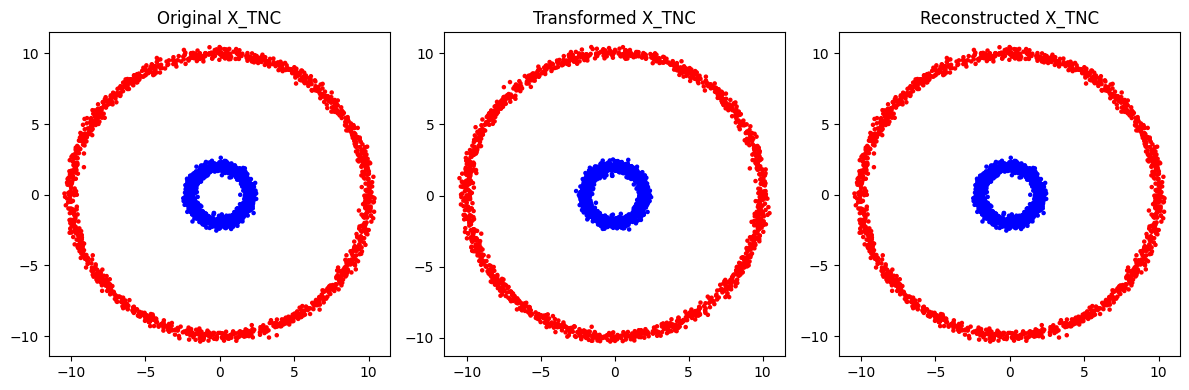

In [15]:
# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plotting Original Data for X_TNC
axs[0].scatter(X_TNC[:, 0], X_TNC[:, 1], c=Y_TNC, cmap='bwr', s=5)
axs[0].set_title('Original X_TNC')

# Plotting Transformed Data for X_TNC
axs[1].scatter(T_TNC[:, 0], T_TNC[:, 1], c=Y_TNC, cmap='bwr', s=5)
axs[1].set_title('Transformed X_TNC')

# Plotting Reconstructed Data for X_TNC
axs[2].scatter(reconstructed_TNC[:, 0], reconstructed_TNC[:, 1], c=Y_TNC, cmap='bwr', s=5)
axs[2].set_title('Reconstructed X_TNC')

plt.tight_layout()
plt.show()

### LFW Visualization:

In the case of the LFW dataset, we are working with around 500 samples, each represented in an approximately 3000-dimensional feature space. Visualizing data in such a high-dimensional space is not feasible, and even after applying PCA to reduce the dimensions to around 200, visual interpretation remains challenging. To address this, we project the data onto a 2D plane, enabling us to better visualize and understand the underlying structure. Although this 2D representation no longer reflects the pixel values of the original images, it captures the most important variance in the data, allowing us to interpret patterns and relationships more easily in the reduced space.


As a result, we can only see the scatter plot of the first two most important new features.

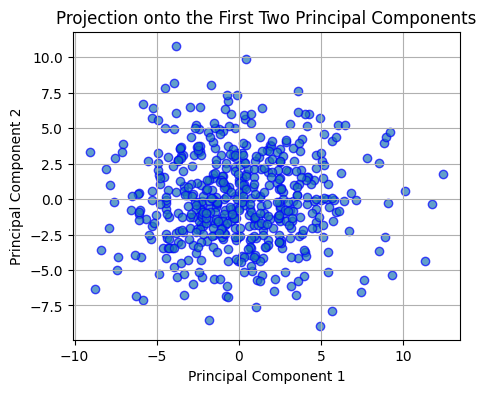

In [16]:
# Extract the first two principal components for plotting
pc1 = T_bush[:, 0]  # First principal component (PC1)
pc2 = T_bush[:, 1]  # Second principal component (PC2)

# Plotting the first two principal components
plt.figure(figsize=(5, 4))
plt.scatter(pc1, pc2, alpha=0.7, edgecolors='b')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Projection onto the First Two Principal Components')
plt.grid(True)
plt.show()

Moreover, some information is lost when reducing the dimensionality of the data. This can be observed by plotting the reconstructed image for a specific instance.

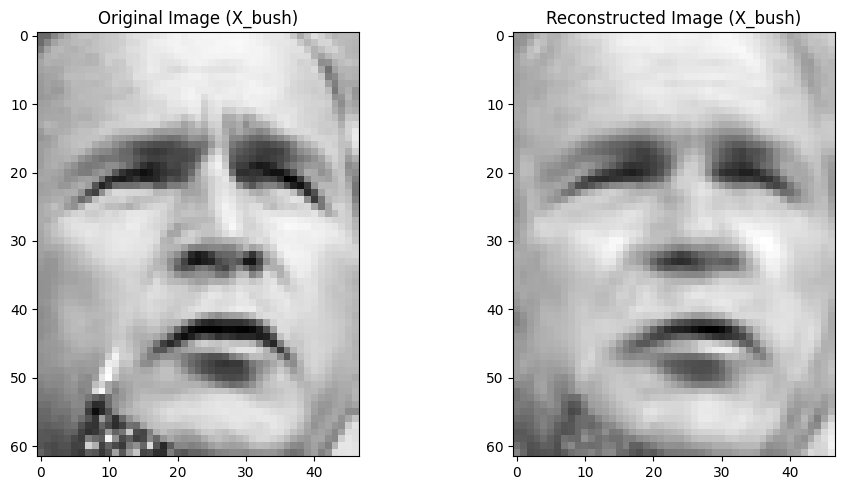

In [17]:
index = 0  # Choose an index of the image you want to show (e.g., the first image)


original_image = X_bush[index].reshape(image_height, image_width)
reconstructed_image = reconstructed_bush[index].reshape(image_height, image_width)

# Plotting the results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plotting Original Image from X_bush
axs[0].imshow(original_image, cmap='gray')
axs[0].set_title('Original Image (X_bush)')


# Plotting Reconstructed Image from X_bush
axs[1].imshow(reconstructed_image, cmap='gray')
axs[1].set_title('Reconstructed Image (X_bush)')

plt.tight_layout()
plt.show()

# <font color="red">Task 3: Average Reconstruction Error for LFW (30 points)</font>
Split the image dataset into train (400 images) and test (rest of the data) datasets.
Train PCA with [2, 10, 30, 60, 100] components respectively. Reconstruction error is defined as

\begin{align}
\text{error}=\frac{1}{n}\sum_{i=1}^n||x_i-\text{reconstruct}(pca(x_i))||^2_2
\end{align}

## <font color="#D2691E">Part A (20 points): </font>

Plot average reconstruction error on training and testing data points with the following requirements:
  1. X-axis shows number of components.
  2. Y-axis shows reconstruction error.
  3. Draw two graphs, one for training and the other line for testing.


In [18]:
# Define the number of components to test in PCA
c_components = [2, 10, 30, 60, 100]

# Initialize lists to store the reconstruction errors for training and testing data
train_errors, test_errors = [], []

# Initialize deterministic seed
SEED = 42

X_train, X_test = train_test_split(X_bush, train_size=400, random_state=SEED)


# \text{error}=\frac{1}{n}\sum_{i=1}^n||x_i-\text{reconstruct}(pca(x_i))||^2_2
def mse(train_data, reconstructed):
  return np.mean(np.sum((train_data - reconstructed) ** 2, axis=1))


# Loop through each specified number of components for PCA
for n_components in c_components:
  # Apply PCA and then inverse PCA to the training data
  transformed_train, Vt_train, mean_train = pca_transform(X_train, n_components)

  # Calculate the Mean Squared Error (MSE) as the reconstruction error for the training set
  train_errors.append(mse(X_train, pca_inverse_transform(transformed_train, Vt_train, n_components, mean_train)))
  # Normalize the test data. Transform the test data using the train data's PCA components # and reconstruct the test data.
  # Calculate the Mean Squared Error (MSE) as the reconstruction error for the test set
  test_errors.append(
    mse(
      X_test,
      pca_inverse_transform(
        (X_test - mean_train) @ pca_components(Vt_train, n_components).T, Vt_train, n_components, mean_train
      ),
    )
  )

# Print the average reconstruction errors for each number of components
for i, n_components in enumerate(c_components):
  print(f'Components: {n_components}\n  Train Error: {train_errors[i]:.4f}\n  Test Error: {test_errors[i]:.4f}')

Components: 2
  Train Error: 40.2048
  Test Error: 44.1277
Components: 10
  Train Error: 21.6275
  Test Error: 25.1425
Components: 30
  Train Error: 11.6392
  Test Error: 15.6092
Components: 60
  Train Error: 6.6892
  Test Error: 11.4092
Components: 100
  Train Error: 3.7635
  Test Error: 8.7075


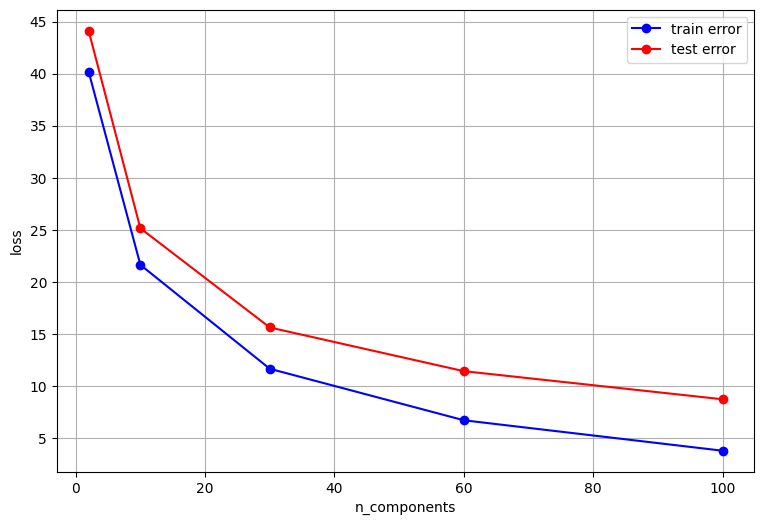

In [19]:
def plot_eval_results(c_components, train_error, test_error):
  plt.figure(figsize=(6 * 1.5, 5 * 1.2))
  plt.plot(c_components, train_error, 'b-o', label='train error')
  plt.plot(c_components, test_error, 'r-o', label='test error')
  plt.xlabel('n_components')
  plt.ylabel('loss')
  plt.legend()
  plt.grid(True)
  plt.show()


plot_eval_results(c_components, train_errors, test_errors)

## <font color="#D2691E">Part B (10 points): </font>

1. Explains the difference between the two graphs (8 points).

2. What would the error be if we compute it for the TNC dataset while using two components and 2000 samples for training? (2 points)

In [20]:
# Define the number of components to test in PCA
n_components = 2

TNC_train, TNC_test = train_test_split(X_TNC, train_size=2000, random_state=SEED)
transformed_TNC_train, Vt_TNC_train, mean_TNC_train = pca_transform(TNC_train, n_components)
train_error = mse(TNC_train, pca_inverse_transform(transformed_TNC_train, Vt_TNC_train, n_components, mean_TNC_train))
test_error = mse(
  TNC_test,
  pca_inverse_transform(
    (TNC_test - mean_TNC_train) @ pca_components(Vt_TNC_train, n_components).T,
    Vt_TNC_train,
    n_components,
    mean_TNC_train,
  ),
)

# Print the average reconstruction errors for each number of components
print(f'Average reconstruction error for train data is {train_error}')
print(f'Average reconstruction error for test data is {test_error}')

Average reconstruction error for train data is 6.217495281310197e-30
Average reconstruction error for test data is 1.2387388672271008e-30


# <font color="red">Task 4: Kernel PCA (30 points)</font>

KernelPCA is an extension of PCA that uses kernel methods to perform dimensionality reduction in a high-dimensional space. Unlike standard PCA, which finds linear components, Kernel PCA can capture non-linear relationships in the data by implicitly mapping it into a higher-dimensional space using a kernel function. In this task, we will use the Radial Basis Function (RBF) kernel, which is similar to a Gaussian kernel.

The `gamma` parameter in the RBF kernel influences the spread of the kernel function. It is analogous to the inverse of the standard deviation (`gamma=1/sigma`) of the Gaussian. A lower `gamma` value results in a wider influence of each training point, while a higher `gamma` value makes the influence more localized. You can read more about the `gamma` parameter [here](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html).

For this task, you don't need to implement Kernel PCA from scratch; use scikit-learn's `KernelPCA` (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html).

An example setup for scikit-learn's Kernel PCA is:

```python
  KernelPCA(kernel='rbf', n_components=100, gamma=0.1, fit_inverse_transform=True)
```

Now, let's proceed with the following parts:

## <font color="#D2691E">Part A (10 points): </font>

### **Apply Kernel PCA and Plot Transformed Data**:

First plot the original TNC data again. Now start by applying Kernel PCA on the TNC dataset using different values of `gamma` (e.g., 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1). For each value of `gamma`, plot the transformed data to visualize the effect of the RBF kernel on the dataset. This step will help you understand how `gamma` influences the data's representation in the transformed space.


For this part you need to plot 12 figures (one for original data, and the other 11 ones for different values of `gamma`).

In [21]:
# Load the dataset
data = pd.read_csv(SYNTHETIC_FILE)

# Split features and labels
X_TNC = data[['coord_x', 'coord_y']].values
Y_TNC = data['label'].values

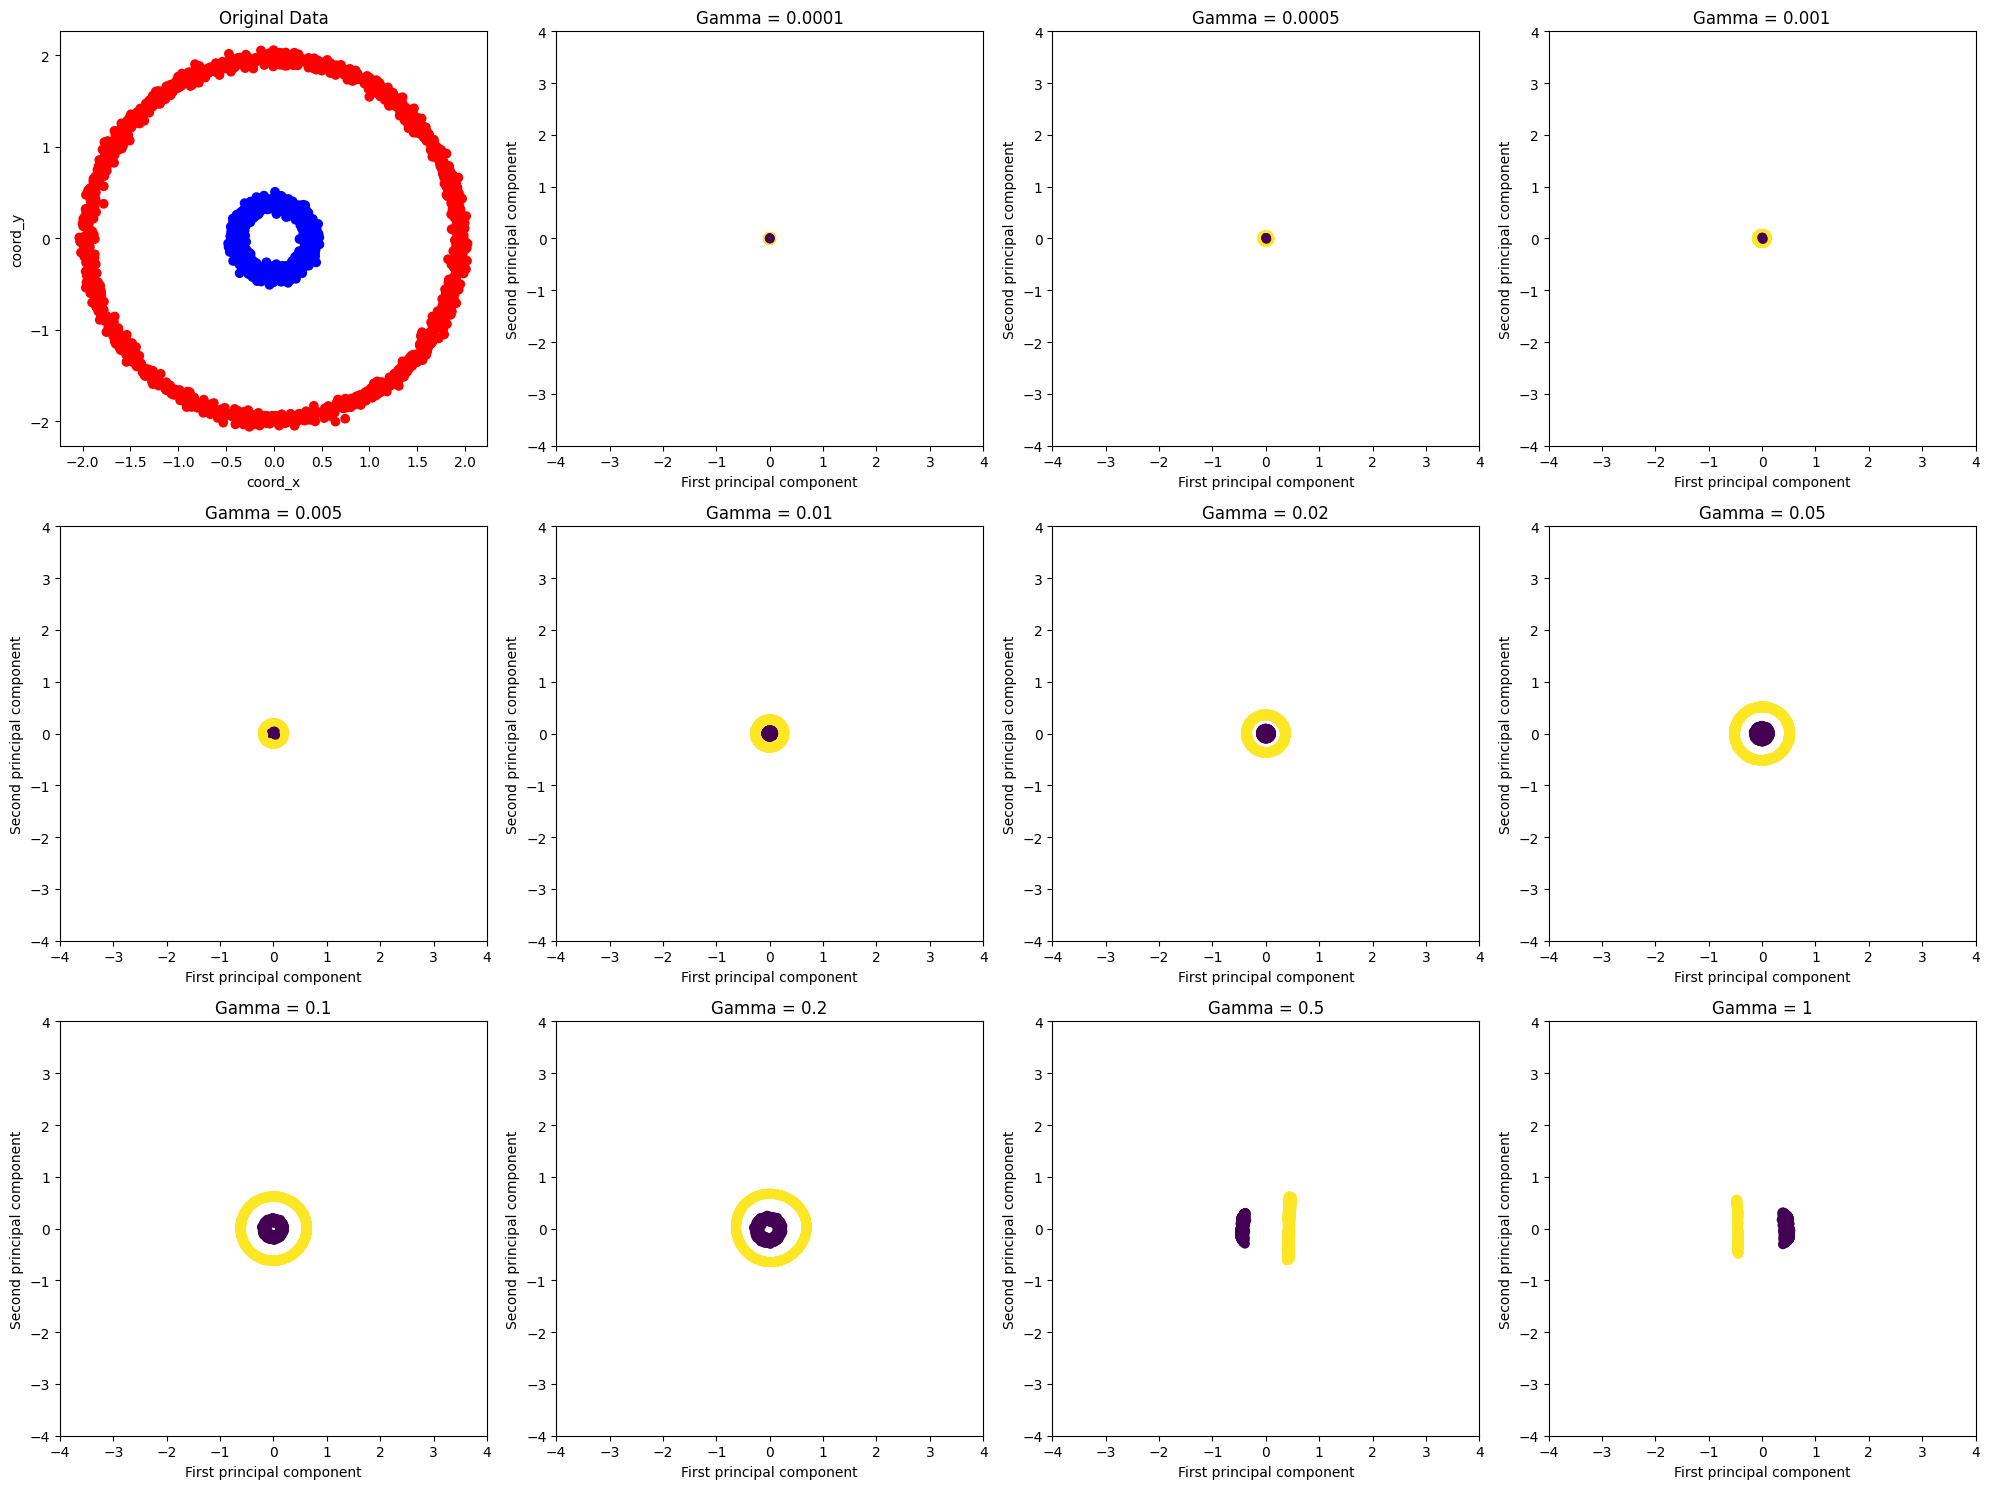

In [22]:
# Define different values of gamma to test
gamma_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
n_components = 2

# Standardize the features
scaler = StandardScaler()
X_TNC_scaled = scaler.fit_transform(X_TNC)

# Create subplots to visualize the transformed data for each gamma
plt.figure(figsize=(20, 15))

# Plot the original data before applying Kernel PCA
plt.subplot(3, 4, 1)
plt.scatter(X_TNC_scaled[:, 0], X_TNC_scaled[:, 1], c=Y_TNC, cmap='bwr')
plt.title('Original Data')
plt.xlabel('coord_x')
plt.ylabel('coord_y')

# Set the limits for the x and y axes
x_limits, y_limits = (-4, 4), (-4, 4)

# Apply Kernel PCA for each gamma value
for idx, gamma in enumerate(gamma_values):
  # Apply Kernel PCA
  kpca = KernelPCA(n_components=n_components, kernel='rbf', gamma=gamma)
  X_kpca = kpca.fit_transform(X_TNC_scaled)

  # Plot the transformed data
  plt.subplot(3, 4, idx + 2)
  plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=Y_TNC, cmap='viridis')
  plt.title(f'Gamma = {gamma}')
  plt.xlabel('First principal component')
  plt.ylabel('Second principal component')
  # Set fixed x and y axis limits
  plt.xlim(x_limits)
  plt.ylim(y_limits)

plt.tight_layout()
plt.show();

## <font color="#D2691E">Part B (5 points): </font>

Based on your observations, how does Kernel PCA compare to Linear PCA on this dataset with red and blue labels? In what ways does Kernel PCA affect the distribution of the data points, particularly in terms of how well the red and blue points are organized? Choose the best value(s) for `gamma` and report it (them). What criteria did you use to determine the optimal `gamma` value?



## <font color="#D2691E">Part C (5 points): </font>

### **Find the Best Values for Reconstruction Error of Kernel PCA**

In this part, you will tune two hyperparameters: `gamma` (values: [0.01, 0.05, 0.1, 0.5, 1]) and `n_components` (values: [2, 10, 30, 60, 100]) for the LFW dataset. Set the train size to 400 samples. Your objective is to find the best combination of `gamma` and `n_components` based on the reconstruction error. Present your results in two tables showing the reconstruction error for each combination on the training set and the test set.


In [23]:
# Define the hyperparameter ranges
gamma_values = [0.005, 0.01, 0.05, 0.1, 0.5]
n_components_values = [2, 10, 30, 60, 100]

X_train, X_test = train_test_split(X_bush, train_size=400, random_state=SEED)

train_errors = {gamma: [] for gamma in gamma_values}
test_errors = {gamma: [] for gamma in gamma_values}

# Loop through each combination of gamma and n_components
for gamma in gamma_values:
  for n_components in n_components_values:
    # Fit KernelPCA
    kpca = KernelPCA(n_components=n_components, kernel='rbf', gamma=gamma, fit_inverse_transform=True)
    X_train_kpca = kpca.fit_transform(X_train)
    X_test_kpca = kpca.transform(X_test)

    # Reconstruct the data
    X_train_reconstructed = kpca.inverse_transform(X_train_kpca)
    X_test_reconstructed = kpca.inverse_transform(X_test_kpca)
    train_errors[gamma].append(mse(X_train, X_train_reconstructed))
    test_errors[gamma].append(mse(X_test, X_test_reconstructed))

train_errors_df = pd.DataFrame(train_errors, index=n_components_values)
test_errors_df = pd.DataFrame(test_errors, index=n_components_values)

# Display the results as tables
print('Reconstruction Error for Training Set:')
print(train_errors_df)
print('\nReconstruction Error for Testing Set:')
print(test_errors_df)

# Find the best combination
best_n_components, best_gamma = np.unravel_index(test_errors_df.values.argmin(), test_errors_df.shape)
best_error = test_errors_df.values[best_n_components, best_gamma]

print(
  f'Best combination:\n  Gamma: {gamma_values[best_gamma]} - n_components: {n_components_values[best_n_components]}\n  test error: {best_error}'
)

Reconstruction Error for Training Set:
         0.005      0.010      0.050      0.100      0.500
2    56.035629  52.460106  59.473942  62.702892  62.768883
10   54.013870  48.537128  54.149078  59.908009  62.227745
30   53.707760  47.722954  52.062382  57.340527  61.118011
60   53.642696  47.483402  50.792248  54.513866  57.952980
100  53.620888  47.394039  49.331505  52.528706  51.324707

Reconstruction Error for Testing Set:
         0.005      0.010      0.050      0.100      0.500
2    60.903149  57.393143  65.655075  68.015724  68.021919
10   58.914120  53.705605  62.367989  67.361328  67.999069
30   58.638409  53.019703  61.464310  67.065262  68.198509
60   58.598793  52.895687  61.163082  66.958488  69.903511
100  58.587997  52.866302  61.069897  67.134178  78.636238
Best combination:
  Gamma: 0.01 - n_components: 100
  test error: 52.866302490234375


## <font color="#D2691E">Part D (10 points): </font>


### **Visualization of Reconstruction Error** (5 points)

Plot the average reconstruction error on both the training and testing data with the following requirements:
  1. Use `n_components = 60`.
  2. Use same `gamma` as before (values: [0.01, 0.05, 0.1, 0.5, 1])
  3. Train size = 400
  4. The X-axis should display the different values of `gamma`.
  5. The Y-axis should show the reconstruction error.
  6. Draw two graphs: one for the training set and one for the test set.

### **Explanation** (5 points)

How does Kernel PCA compare to Linear PCA on this dataset? If Kernel PCA shows improved performance, please justify your answer. If Linear PCA performs better, explain the reasons for its effectiveness.

**Hint:** Consider factors such as the choice of kernel, the characteristics of the data, and how the `gamma` parameter influences the transformed space.


In [24]:
APPLY_SCALED = False
USE_SKLEARN_PCA = True

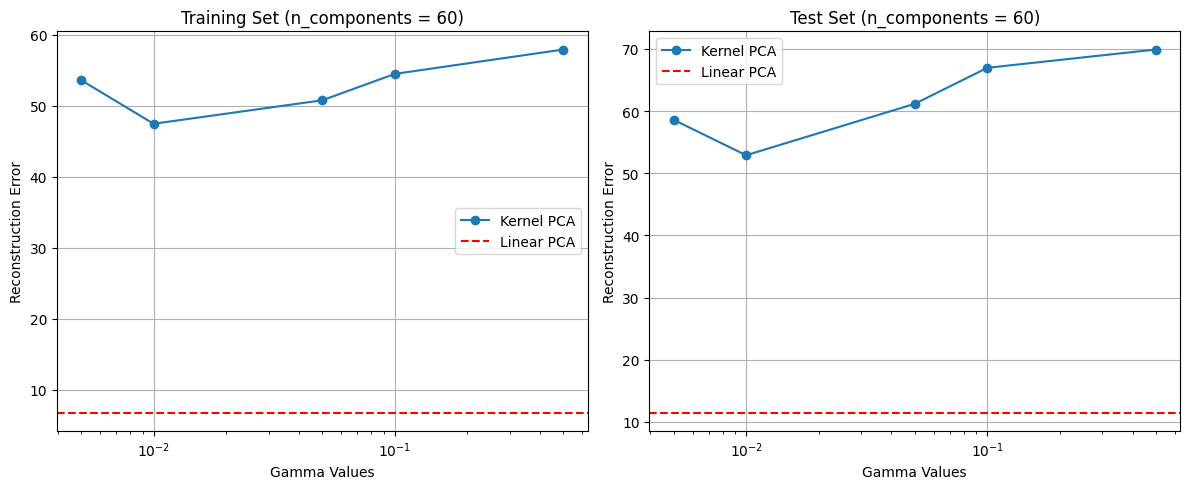

Linear PCA - Train Error: 6.7114, Test Error: 11.4403
Kernel PCA Errors:
  Gamma 0.005 - Train Error: 53.6427, Test Error: 58.5988
  Gamma 0.010 - Train Error: 47.4834, Test Error: 52.8957
  Gamma 0.050 - Train Error: 50.7922, Test Error: 61.1631
  Gamma 0.100 - Train Error: 54.5139, Test Error: 66.9585
  Gamma 0.500 - Train Error: 57.9530, Test Error: 69.9035


In [25]:
# Choose n_components = 60 for visualization
n_components = 60

scaler = StandardScaler()

# Initialize lists to store errors
train_errors_kpca = []
test_errors_kpca = []
train_error_pca = []
test_error_pca = []

X_train, X_test = train_test_split(X_bush, train_size=400, random_state=SEED)

if APPLY_SCALED:
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
else:
  X_train_scaled = X_train
  X_test_scaled = X_test

# Compute errors for Kernel PCA
for gamma in gamma_values:
  kpca = KernelPCA(n_components=n_components, kernel='rbf', gamma=gamma, fit_inverse_transform=True)

  # Train set
  X_train_kpca = kpca.fit_transform(X_train_scaled)
  X_train_reconstructed = kpca.inverse_transform(X_train_kpca)
  train_errors_kpca.append(mse(X_train_scaled, X_train_reconstructed))

  # Test set
  X_test_kpca = kpca.transform(X_test_scaled)
  X_test_reconstructed = kpca.inverse_transform(X_test_kpca)
  test_errors_kpca.append(mse(X_test_scaled, X_test_reconstructed))

# Linear PCA
if not USE_SKLEARN_PCA:
  transformed_bush_train, Vt_bush_train, mean_bush_train = pca_transform(X_train_scaled, n_components)
  train_error_pca.append(
    mse(X_train, pca_inverse_transform(transformed_bush_train, Vt_train, n_components, mean_train))
  )
  test_error_pca.append(
    mse(
      X_test_scaled,
      pca_inverse_transform(
        (X_test_scaled - mean_train) @ pca_components(Vt_train, n_components).T, Vt_train, n_components, mean_train
      ),
    )
  )
else:
  # sklearn PCA
  pca = PCA(n_components=n_components)
  X_train_pca = pca.fit_transform(X_train_scaled)
  X_train_reconstructed_pca = pca.inverse_transform(X_train_pca)
  train_error_pca.append(mse(X_train, X_train_reconstructed_pca))

  X_test_pca = pca.transform(X_test_scaled)
  X_test_reconstructed_pca = pca.inverse_transform(X_test_pca)
  test_error_pca.append(mse(X_test, X_test_reconstructed_pca))


# Plot the results
plt.figure(figsize=(12, 5))

# Plot for training set
plt.subplot(1, 2, 1)
plt.plot(gamma_values, train_errors_kpca, marker='o', label='Kernel PCA')
plt.axhline(y=train_error_pca, color='r', linestyle='--', label='Linear PCA')
plt.xlabel('Gamma Values')
plt.ylabel('Reconstruction Error')
plt.title(f'Training Set (n_components = {n_components})')
plt.legend()
plt.xscale('log')
plt.grid(True)

# Plot for test set
plt.subplot(1, 2, 2)
plt.plot(gamma_values, test_errors_kpca, marker='o', label='Kernel PCA')
plt.axhline(y=test_error_pca, color='r', linestyle='--', label='Linear PCA')
plt.xlabel('Gamma Values')
plt.ylabel('Reconstruction Error')
plt.title(f'Test Set (n_components = {n_components})')
plt.legend()
plt.xscale('log')
plt.grid(True)


plt.tight_layout()
plt.show()

print(f'Linear PCA - Train Error: {train_error_pca[0]:.4f}, Test Error: {test_error_pca[0]:.4f}')
print('Kernel PCA Errors:')
for gamma, train_err, test_err in zip(gamma_values, train_errors_kpca, test_errors_kpca):
  print(f'  Gamma {gamma:.3f} - Train Error: {train_err:.4f}, Test Error: {test_err:.4f}')